In [1]:
# --------------------------
# 1. Import Libraries
# --------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# --------------------------
# 2. Load Data
# --------------------------
df = pd.read_csv("loan_applications.csv")

# --------------------------
# 3. Data Preprocessing
# --------------------------
# Drop unnecessary columns
df.drop(['fraud_type', 'fraud_flag', 'loan_status', 'gender',
         'residential_address', 'loan_type', 'debt_to_income_ratio'],
        axis=1, inplace=True)

# Calculate monthly interest and loan payments
df['interest_loan_per_month'] = (df['loan_amount_requested'] *
                                   (df['interest_rate_offered'] / 100) *
                                   df['loan_tenure_months']) / (df['loan_tenure_months'] * 12)

df['loan_per_month'] = (df['loan_amount_requested'] / df['loan_tenure_months']) + df['interest_loan_per_month']
df['emi_with_loan_per_month'] = df['loan_per_month'] + df['existing_emis_monthly']
df['ratio_to_pay_per_month'] = df['emi_with_loan_per_month'] / df['monthly_income']

# Identify non-numeric columns
list_column = df.columns.to_list()
bukan_numerik = [i for i in list_column if df[i].dtype == 'O']

# Encode categorical variables
def encode_range(x):
    if 801 <= x <= 900:
        return 1
    elif 751 <= x <= 800:
        return 2
    elif 701 <= x <= 750:
        return 3
    elif 601 <= x <= 700:
        return 4
    elif 300 <= x <= 600:
        return 5
    else:
        return 5

encoder_purpose = {
    'Medical Emergency': 1,
    'Business Expansion': 2,
    'Education': 3,
    'Wedding': 4,
    'Home Renovation': 5,
    'Vehicle Purchase': 6,
    'Debt Consolidation': 7,
}

encoder_employ = {
    'Salaried': 1,
    'Self-Employed': 2,
    'Business Owner': 3,
    'Retired': 4,
    'Unemployed': 5,
    'Student': 6
}

encoder_property = {
    'Owned': 1,
    'Jointly Owned': 2,
    'Rented': 3
}

df['encoded_purpose_of_loan'] = df['purpose_of_loan'].map(encoder_purpose)
df['encoded_employment_status'] = df['employment_status'].map(encoder_employ)
df['encoded_property_ownership_status'] = df['property_ownership_status'].map(encoder_property)
df['encoded_cibil_score'] = df['cibil_score'].apply(encode_range)

# Drop columns that are no longer needed
df_digunakan = df.drop(['application_id', 'application_date', 'existing_emis_monthly',
                        'interest_rate_offered', 'purpose_of_loan',
                        'employment_status', 'property_ownership_status',
                        'cibil_score'], axis=1)

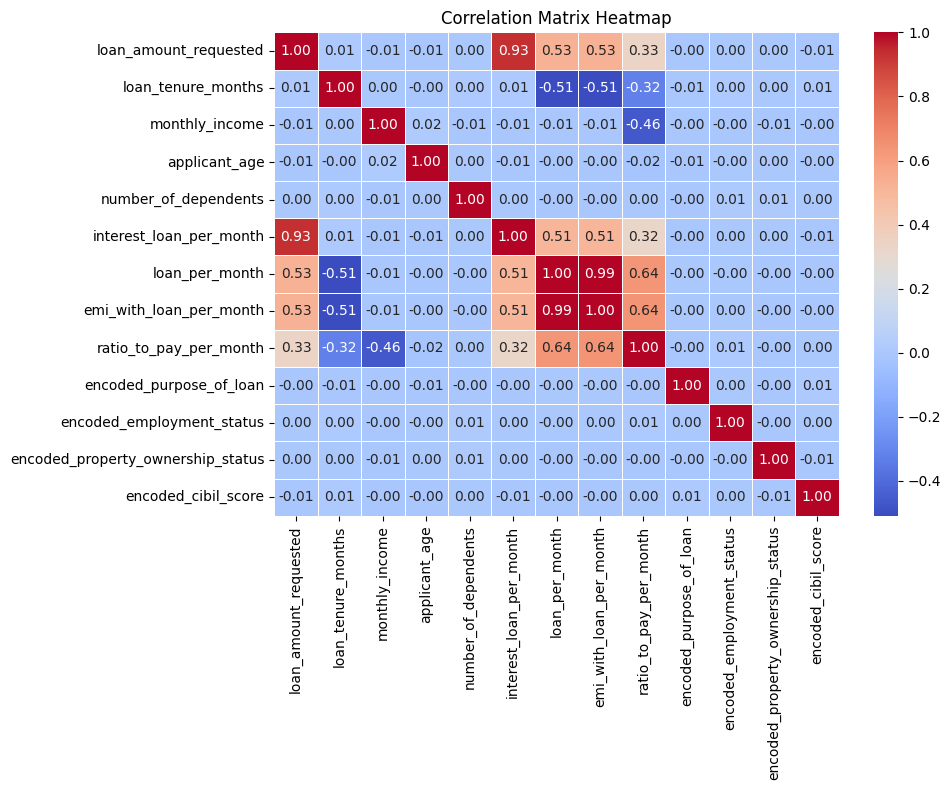

In [3]:
# --------------------------
# 4. Visualize Correlation Matrix
# --------------------------
corr_matrix = df_digunakan.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

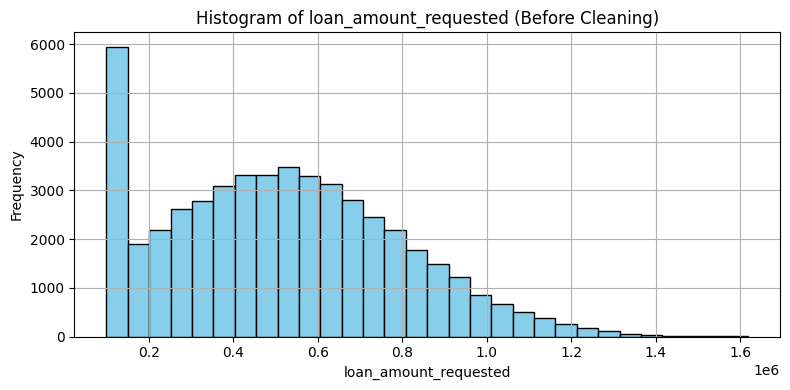

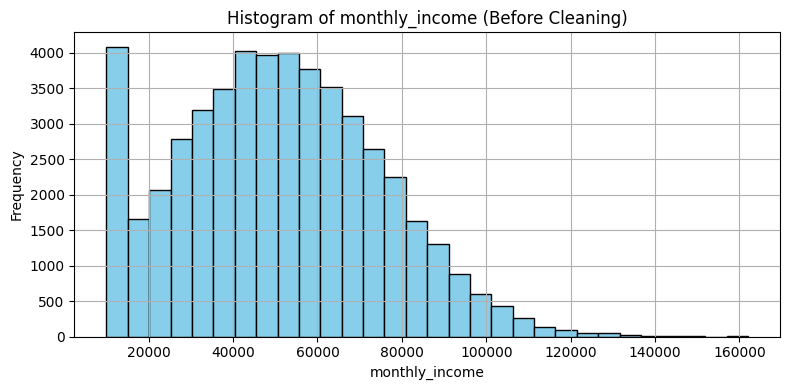

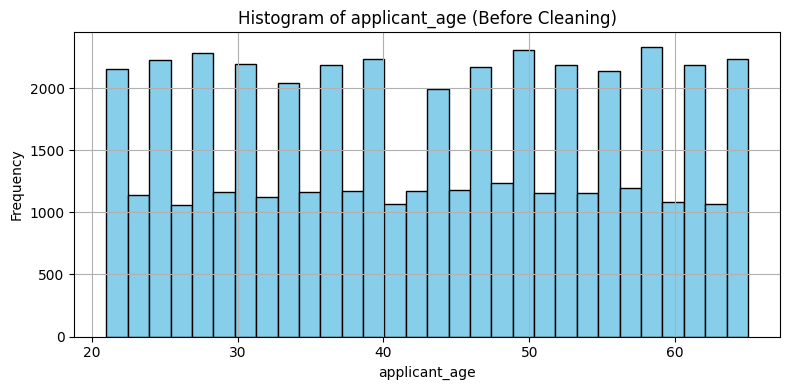

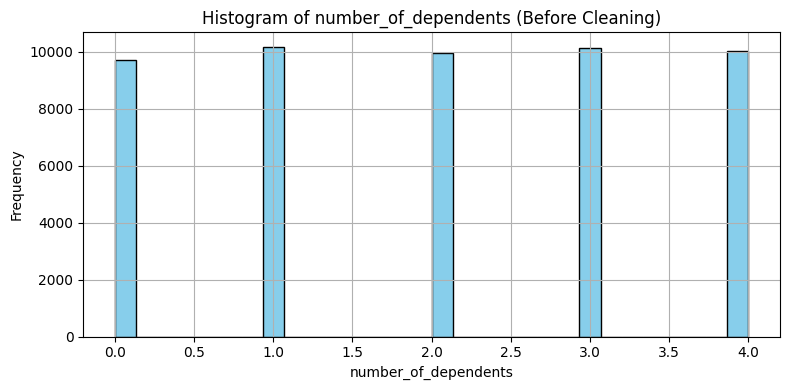

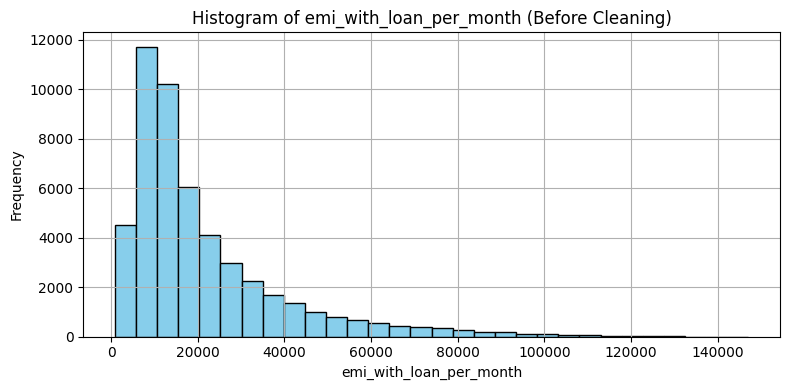

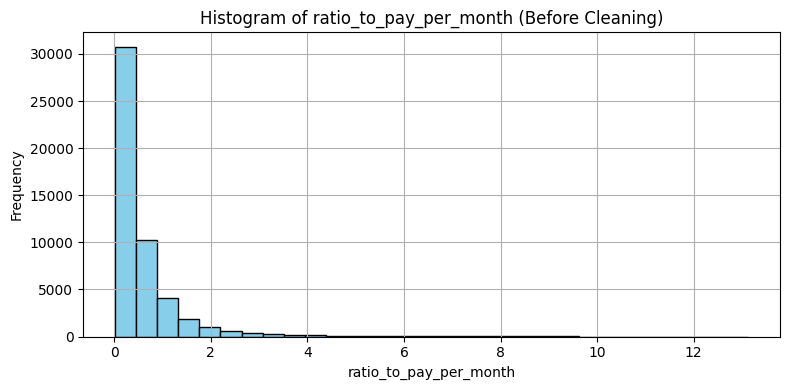

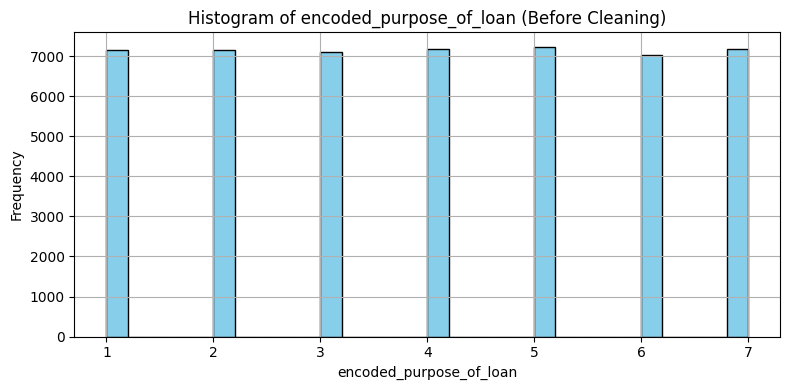

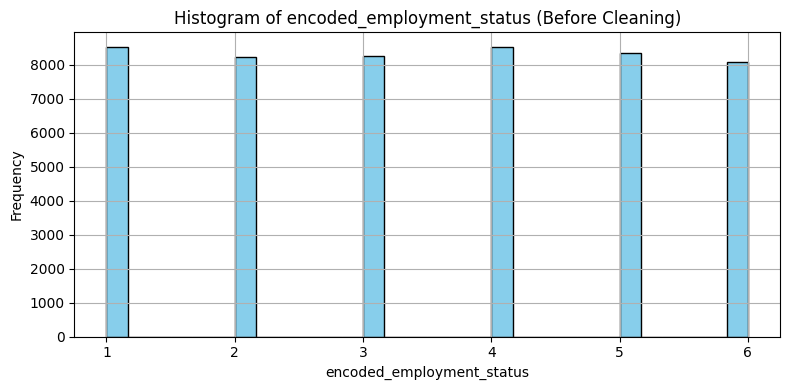

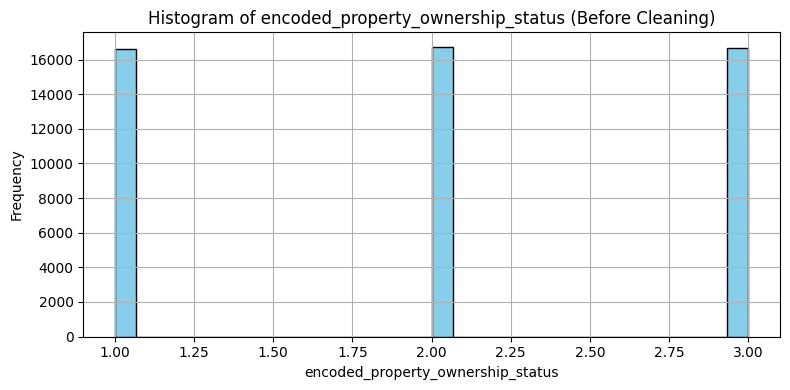

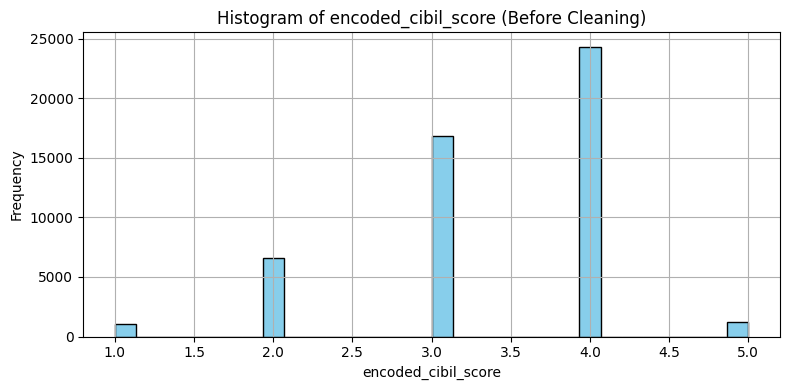

In [4]:
# --------------------------
# 5. Visualize Distributions Before Cleaning
# --------------------------
pakeini = df_digunakan.drop(['interest_loan_per_month', 'loan_per_month', 'loan_tenure_months'], axis=1)

for column in pakeini.columns:
    if pd.api.types.is_numeric_dtype(pakeini[column]):
        plt.figure(figsize=(8, 4))
        plt.hist(pakeini[column], bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {column} (Before Cleaning)')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [5]:
# --------------------------
# 6. Remove Outliers
# --------------------------
# Outlier removal for 'emi_with_loan_per_month'
Q1 = pakeini['emi_with_loan_per_month'].quantile(0.25)
Q3 = pakeini['emi_with_loan_per_month'].quantile(0.75)
IQR = Q3 - Q1
mask = (pakeini['emi_with_loan_per_month'] >= (Q1 - 1.5 * IQR)) & (pakeini['emi_with_loan_per_month'] <= (Q3 + 1.5 * IQR))
pakeini_cleaned = pakeini[mask].reset_index(drop=True)

# Outlier removal for 'ratio_to_pay_per_month'
Q1 = pakeini_cleaned['ratio_to_pay_per_month'].quantile(0.25)
Q3 = pakeini_cleaned['ratio_to_pay_per_month'].quantile(0.75)
IQR = Q3 - Q1
mask = (pakeini_cleaned['ratio_to_pay_per_month'] >= (Q1 - 1.5 * IQR)) & (pakeini_cleaned['ratio_to_pay_per_month'] <= (Q3 + 1.5 * IQR))
pakeini_cleaned_cleaned = pakeini_cleaned[mask].reset_index(drop=True)

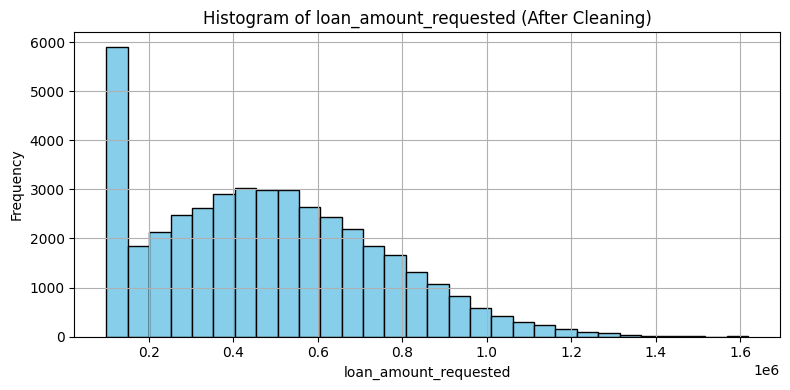

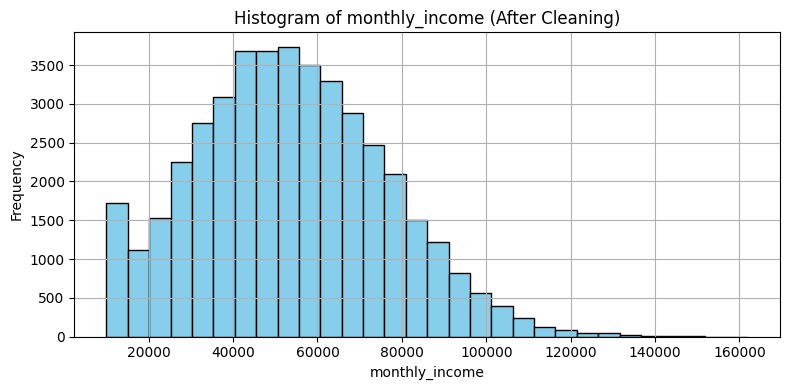

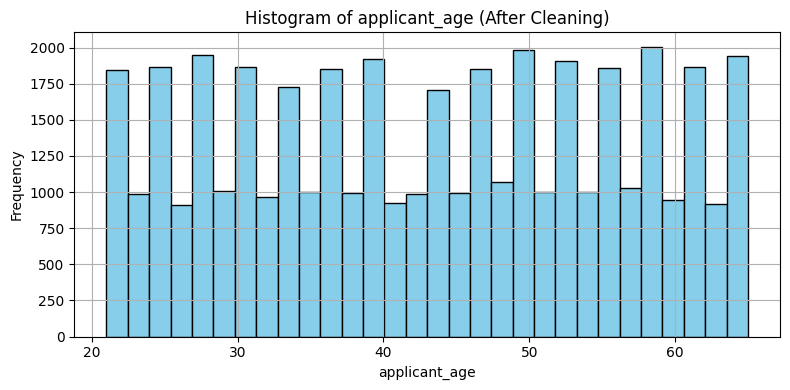

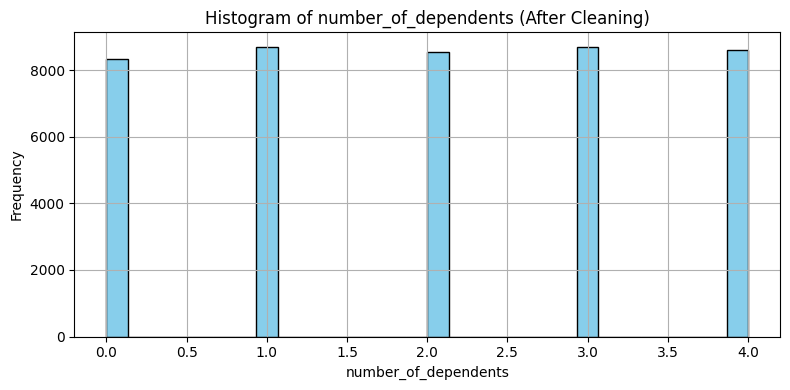

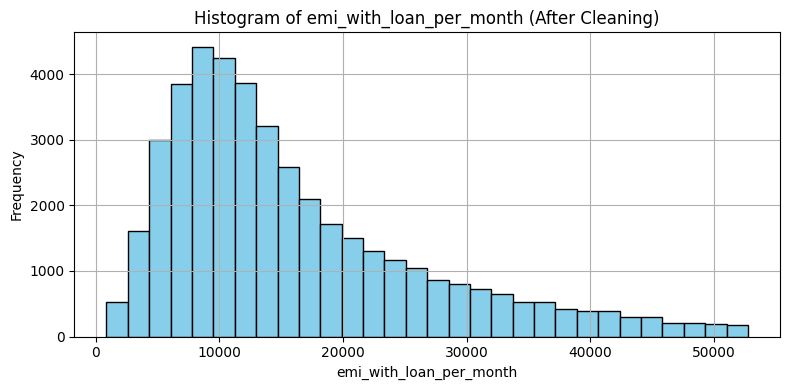

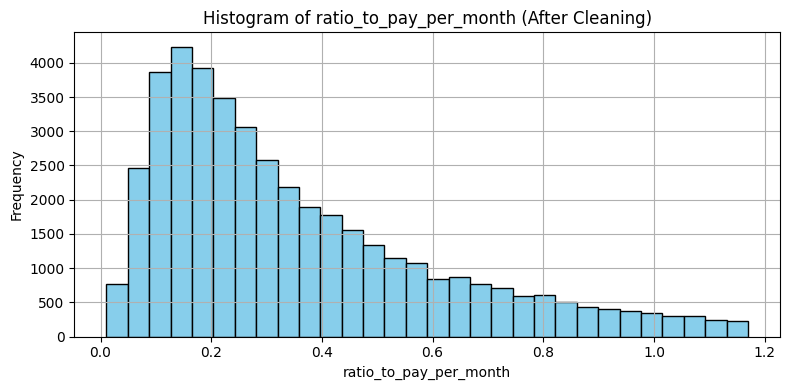

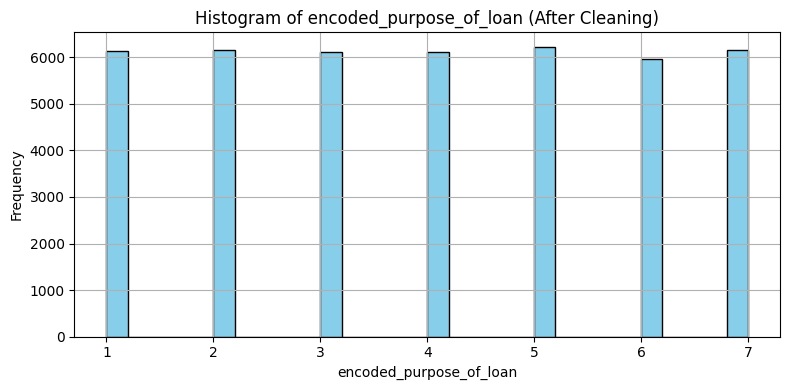

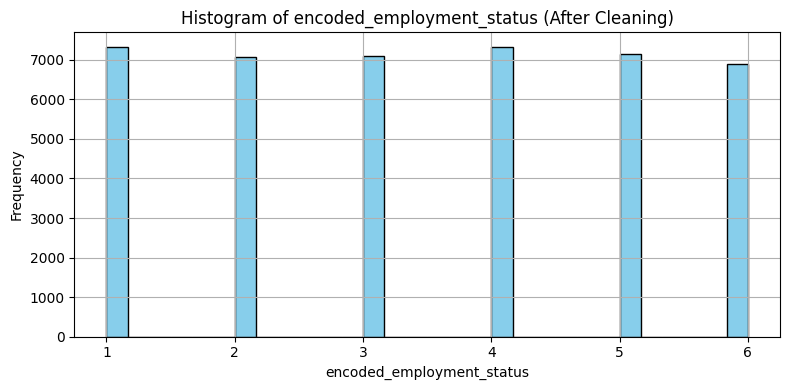

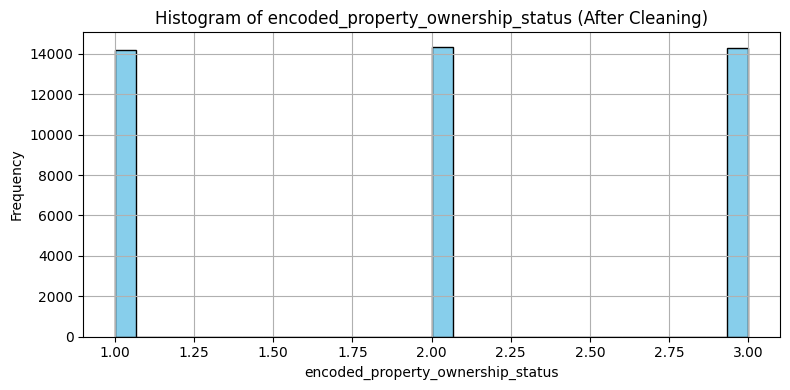

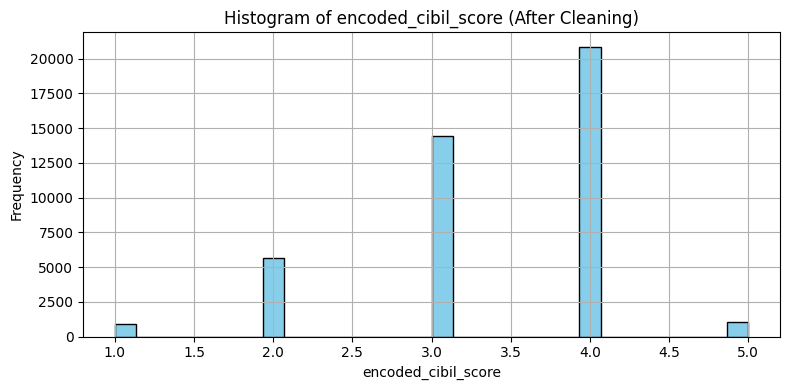

In [6]:
# --------------------------
# 7. Visualize Distributions After Cleaning
# --------------------------
for column in pakeini_cleaned_cleaned.columns:
    if pd.api.types.is_numeric_dtype(pakeini_cleaned_cleaned[column]):
        plt.figure(figsize=(8, 4))
        plt.hist(pakeini_cleaned_cleaned[column], bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {column} (After Cleaning)')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [7]:
# --------------------------
# 8. Clustering with SOM
# --------------------------
# Prepare data for SOM
X_ordinal = pakeini_cleaned_cleaned[['encoded_purpose_of_loan', 'encoded_employment_status',
                                      'encoded_property_ownership_status', 'encoded_cibil_score']]
X_numerik = pakeini_cleaned_cleaned[['ratio_to_pay_per_month', 'emi_with_loan_per_month',
                                       'applicant_age', 'number_of_dependents',
                                       'loan_amount_requested', 'monthly_income']]

# Scale the data
scaler = MinMaxScaler()
X_numerik_scaled = scaler.fit_transform(X_numerik)
X_ordinal_scaled = scaler.fit_transform(X_ordinal)
X = np.hstack((X_numerik_scaled, X_ordinal_scaled))

# Implement Simple SOM
class SimpleSOM:
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5):
        self.x = x
        self.y = y
        self.input_len = input_len
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.weights = np.random.rand(x, y, input_len)

    def _neighborhood(self, win_x, win_y, it, max_iter):
        sigma = self.sigma * (1 - it / max_iter)
        learning_rate = self.learning_rate * (1 - it / max_iter)
        D = np.zeros((self.x, self.y))
        for i in range(self.x):
            for j in range(self.y):
                dist_sq = (win_x - i)**2 + (win_y - j)**2
                D[i, j] = np.exp(-dist_sq / (2 * (sigma**2)))
        return D * learning_rate

    def winner(self, x):
        distances = np.linalg.norm(self.weights - x.reshape(1, 1, -1), axis=2)
        win_idx = np.unravel_index(np.argmin(distances), (self.x, self.y))
        return win_idx

    def train(self, data, num_iteration=1000):
        for it in range(num_iteration):
            x = data[np.random.randint(0, len(data))]
            win_x, win_y = self.winner(x)
            h = self._neighborhood(win_x, win_y, it, num_iteration).reshape(self.x, self.y, 1)
            self.weights += h * (x - self.weights)

# Train SOM
som = SimpleSOM(x=3, y=1, input_len=X.shape[1])
som.train(X, num_iteration=1000)

# Get clusters from winner neuron
win_map = np.array([som.winner(x) for x in X])
clusters = win_map[:, 0]  # because of 3x1 grid
pakeini_cleaned_cleaned['cluster'] = clusters

# Calculate Silhouette Score
sil_score = silhouette_score(X, clusters)
print(f'Silhouette Score: {sil_score:.4f}')

Silhouette Score: 0.1191


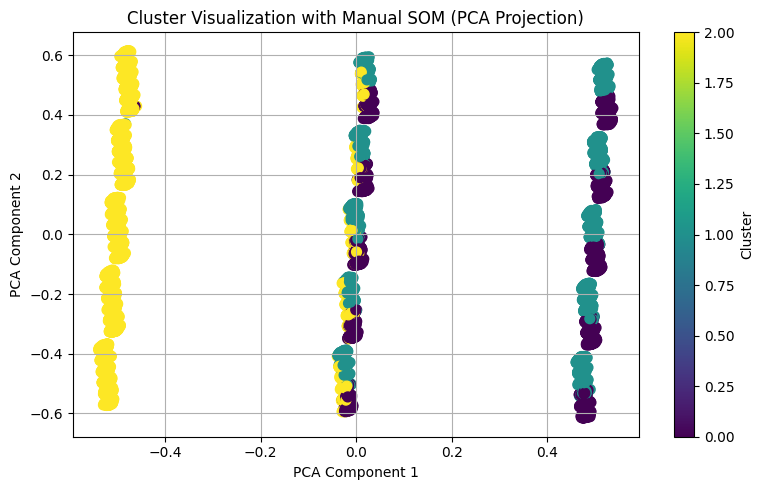

In [8]:
# --------------------------
# 9. Visualize Clusters with PCA
# --------------------------
pca = PCA(n_components=2)
data_2d = pca.fit_transform(X)

plt.figure(figsize=(8, 5))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('Cluster Visualization with Manual SOM (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# --------------------------
# 10. Summary of Clusters
# --------------------------
summary = pakeini_cleaned_cleaned.groupby('cluster')[[
    'applicant_age',
    'ratio_to_pay_per_month',
    'emi_with_loan_per_month',
    'encoded_cibil_score',
    'loan_amount_requested',
    'monthly_income'
]].mean().round(2)

print("Ringkasan Karakteristik per Cluster:")
print(summary)

Ringkasan Karakteristik per Cluster:
         applicant_age  ratio_to_pay_per_month  emi_with_loan_per_month  \
cluster                                                                   
0                43.28                    0.36                 16195.54   
1                44.27                    0.38                 16688.47   
2                42.09                    0.33                 15542.37   

         encoded_cibil_score  loan_amount_requested  monthly_income  
cluster                                                              
0                       3.39              484477.66        53187.73  
1                       3.35              486367.54        52546.06  
2                       3.35              470539.08        54986.52  


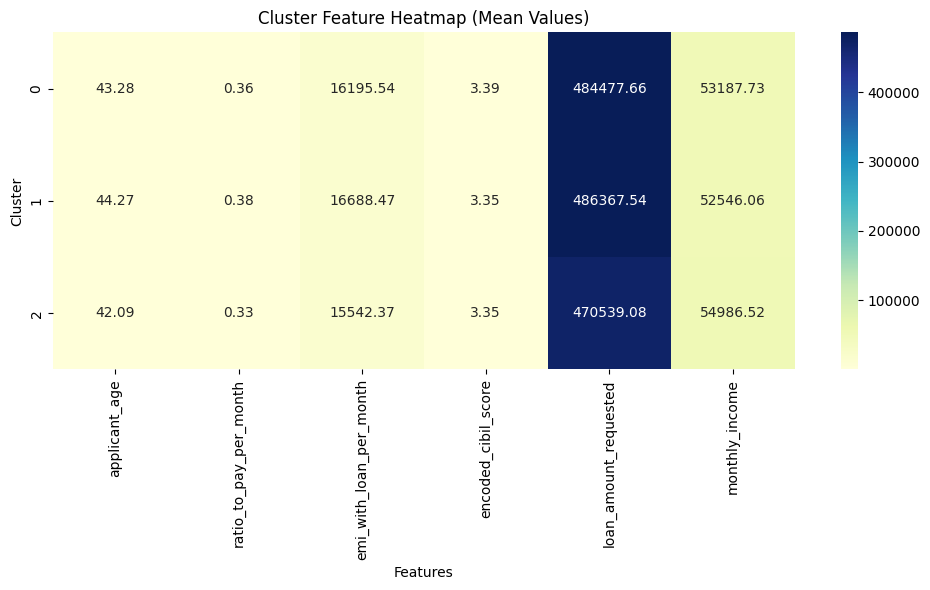

In [10]:
# --------------------------
# 11. Heatmap of Cluster Features
# --------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(summary, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Cluster Feature Heatmap (Mean Values)')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

In [11]:
# --------------------------
# 12. Save Results
# --------------------------
pakeini_cleaned_cleaned.to_excel('cluster_loan8.xlsx', index=False)